In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
df_patient = pd.read_csv('data/icu_cohort_small.csv')
df_patient

,stay_id,hadm_id,subject_id,intime,outtime,icu_los_hours,gender,anchor_age,died_in_hosp
0,37302156,21819818,11417989,2140-11-02 21:07:10,2140-11-02 21:13:32,0,F,31,0
1,33255415,27790400,13941452,2161-05-21 19:34:30,2161-05-21 19:38:40,0,F,33,0
2,34040970,20991814,13447872,2140-12-21 23:12:50,2140-12-21 23:41:20,0,F,34,0
3,36502717,26958979,11331147,2142-05-14 20:10:54,2142-05-14 20:40:34,0,F,43,0
4,33084533,22087634,10971284,2189-05-19 18:42:21,2189-05-19 18:47:20,0,F,48,0
...,...,...,...,...,...,...,...,...,...
94439,31492392,24012265,18503414,2130-09-25 00:38:38,2131-01-30 21:28:57,3069,M,87,1
94440,30359303,26571961,11633737,2187-05-15 21:22:40,2187-09-28 22:04:32,3265,M,48,0
94441,39510663,22329603,18744840,2114-05-26 19:00:32,2114-10-13 20:17:49,3361,F,29,0
94442,36307509,24784126,11336222,2114-01-19 18:28:25,2114-06-28 10:28:37,3832,F,43,0


In [3]:
df_vital = pd.read_csv('data/vitals_ts_small.csv').sort_values(by=['stay_id', 'charttime'])
df_vital['charttime'] = pd.to_datetime(df_vital['charttime'])
df_vital

,stay_id,charttime,variable,value
11100415,30000153,2174-09-29 12:09:00,respiratory rate,18.0
8097302,30000153,2174-09-29 13:00:00,o2 saturation pulseoxymetry,100.0
8826274,30000153,2174-09-29 13:00:00,heart rate,104.0
9594399,30000153,2174-09-29 13:00:00,respiratory rate,16.0
5093009,30000153,2174-09-29 14:00:00,respiratory rate,16.0
...,...,...,...,...
1804833,39999858,2167-04-28 11:00:00,respiratory rate,18.0
10642233,39999858,2167-04-28 11:00:00,o2 saturation pulseoxymetry,98.0
6165405,39999858,2167-04-28 12:00:00,respiratory rate,12.0
7605102,39999858,2167-04-28 12:00:00,heart rate,66.0


In [4]:
# Select first 10,000 patients
first_10k_patients = df_patient.head(10000)
print(f"Selected {len(first_10k_patients)} patients")
print(f"Number who died in hospital: {first_10k_patients['died_in_hosp'].sum()}")
print(f"Mortality rate: {first_10k_patients['died_in_hosp'].mean():.2%}")
first_10k_patients.head()


Selected 10000 patients
Number who died in hospital: 1639
Mortality rate: 16.39%


,stay_id,hadm_id,subject_id,intime,outtime,icu_los_hours,gender,anchor_age,died_in_hosp
0,37302156,21819818,11417989,2140-11-02 21:07:10,2140-11-02 21:13:32,0,F,31,0
1,33255415,27790400,13941452,2161-05-21 19:34:30,2161-05-21 19:38:40,0,F,33,0
2,34040970,20991814,13447872,2140-12-21 23:12:50,2140-12-21 23:41:20,0,F,34,0
3,36502717,26958979,11331147,2142-05-14 20:10:54,2142-05-14 20:40:34,0,F,43,0
4,33084533,22087634,10971284,2189-05-19 18:42:21,2189-05-19 18:47:20,0,F,48,0


In [5]:
# Filter vital signs for the first 10k patients
stay_ids_10k = first_10k_patients['stay_id'].values
df_vital_10k = df_vital[df_vital['stay_id'].isin(stay_ids_10k)]

print(f"Vital sign records for 10k patients: {len(df_vital_10k)}")
print(f"Unique patients: {df_vital_10k['stay_id'].nunique()}")
print(f"\nVariable distribution:")
print(df_vital_10k['variable'].value_counts())


Vital sign records for 10k patients: 393699
Unique patients: 9980

Variable distribution:
variable
heart rate                     134799
respiratory rate               132529
o2 saturation pulseoxymetry    126371
Name: count, dtype: int64


In [6]:
# Aggregate vital signs by patient (calculate mean values)
vital_stats = df_vital_10k.pivot_table(
    index='stay_id',
    columns='variable',
    values='value',
    aggfunc=['mean', 'std', 'min', 'max', 'count']
)

# Flatten column names
vital_stats.columns = ['_'.join(col).strip() for col in vital_stats.columns.values]
vital_stats = vital_stats.reset_index()

# Simplify column names
vital_stats.columns = [col.replace(' ', '_') for col in vital_stats.columns]

print("Aggregated vital statistics shape:", vital_stats.shape)
print("\nColumn names:")
print(vital_stats.columns.tolist())
vital_stats.head()


Aggregated vital statistics shape: (9980, 16)

Column names:
['stay_id', 'mean_heart_rate', 'mean_o2_saturation_pulseoxymetry', 'mean_respiratory_rate', 'std_heart_rate', 'std_o2_saturation_pulseoxymetry', 'std_respiratory_rate', 'min_heart_rate', 'min_o2_saturation_pulseoxymetry', 'min_respiratory_rate', 'max_heart_rate', 'max_o2_saturation_pulseoxymetry', 'max_respiratory_rate', 'count_heart_rate', 'count_o2_saturation_pulseoxymetry', 'count_respiratory_rate']


,stay_id,mean_heart_rate,mean_o2_saturation_pulseoxymetry,mean_respiratory_rate,std_heart_rate,std_o2_saturation_pulseoxymetry,std_respiratory_rate,min_heart_rate,min_o2_saturation_pulseoxymetry,min_respiratory_rate,max_heart_rate,max_o2_saturation_pulseoxymetry,max_respiratory_rate,count_heart_rate,count_o2_saturation_pulseoxymetry,count_respiratory_rate
0,30002012,86.470588,95.117647,18.705882,2.502939,1.268974,3.015889,82.0,93.0,15.0,91.0,97.0,23.0,17.0,17.0,17.0
1,30003202,97.428571,95.800000,17.950000,6.874383,4.479192,2.665076,87.0,78.0,15.0,111.0,100.0,25.0,21.0,20.0,20.0
2,30003729,72.800000,95.066667,17.857143,4.662924,0.883715,4.417746,66.0,94.0,11.0,81.0,96.0,27.0,15.0,15.0,14.0
3,30005363,88.615385,95.153846,17.076923,5.723322,1.519109,3.707235,79.0,93.0,12.0,98.0,98.0,24.0,13.0,13.0,13.0
4,30006506,64.428571,98.928571,15.857143,11.372803,1.384768,3.676477,51.0,96.0,7.0,94.0,100.0,21.0,14.0,14.0,14.0


In [7]:
# Merge with patient data to get died_in_hosp label
analysis_df = vital_stats.merge(
    first_10k_patients[['stay_id', 'died_in_hosp', 'gender', 'anchor_age']], 
    on='stay_id', 
    how='inner'
)

print(f"Analysis dataframe shape: {analysis_df.shape}")
print(f"Patients with complete data: {len(analysis_df)}")
print(f"\nMissing values per column:")
print(analysis_df.isnull().sum())
analysis_df.head()


Analysis dataframe shape: (9980, 19)
Patients with complete data: 9980

Missing values per column:
stay_id                                0
mean_heart_rate                        0
mean_o2_saturation_pulseoxymetry     120
mean_respiratory_rate                 48
std_heart_rate                       270
std_o2_saturation_pulseoxymetry      411
std_respiratory_rate                 321
min_heart_rate                         0
min_o2_saturation_pulseoxymetry      120
min_respiratory_rate                  48
max_heart_rate                         0
max_o2_saturation_pulseoxymetry      120
max_respiratory_rate                  48
count_heart_rate                       0
count_o2_saturation_pulseoxymetry    120
count_respiratory_rate                48
died_in_hosp                           0
gender                                 0
anchor_age                             0
dtype: int64


,stay_id,mean_heart_rate,mean_o2_saturation_pulseoxymetry,mean_respiratory_rate,std_heart_rate,std_o2_saturation_pulseoxymetry,std_respiratory_rate,min_heart_rate,min_o2_saturation_pulseoxymetry,min_respiratory_rate,max_heart_rate,max_o2_saturation_pulseoxymetry,max_respiratory_rate,count_heart_rate,count_o2_saturation_pulseoxymetry,count_respiratory_rate,died_in_hosp,gender,anchor_age
0,30002012,86.470588,95.117647,18.705882,2.502939,1.268974,3.015889,82.0,93.0,15.0,91.0,97.0,23.0,17.0,17.0,17.0,1,F,61
1,30003202,97.428571,95.800000,17.950000,6.874383,4.479192,2.665076,87.0,78.0,15.0,111.0,100.0,25.0,21.0,20.0,20.0,0,M,73
2,30003729,72.800000,95.066667,17.857143,4.662924,0.883715,4.417746,66.0,94.0,11.0,81.0,96.0,27.0,15.0,15.0,14.0,0,F,57
3,30005363,88.615385,95.153846,17.076923,5.723322,1.519109,3.707235,79.0,93.0,12.0,98.0,98.0,24.0,13.0,13.0,13.0,0,M,54
4,30006506,64.428571,98.928571,15.857143,11.372803,1.384768,3.676477,51.0,96.0,7.0,94.0,100.0,21.0,14.0,14.0,14.0,0,F,71


In [8]:
# Create a simplified dataframe with mean values for the three features
corr_df = pd.DataFrame({
    'heart_rate': analysis_df['mean_heart_rate'],
    'respiratory_rate': analysis_df['mean_respiratory_rate'],
    'o2_saturation': analysis_df['mean_o2_saturation_pulseoxymetry'],
    'died_in_hosp': analysis_df['died_in_hosp']
})

# Remove rows with missing values for cleaner correlation analysis
corr_df_clean = corr_df.dropna()

print(f"Clean correlation dataframe shape: {corr_df_clean.shape}")
print(f"Removed {len(corr_df) - len(corr_df_clean)} rows with missing values")
print(f"\nBasic statistics:")
print(corr_df_clean.describe())


Clean correlation dataframe shape: (9823, 4)
Removed 157 rows with missing values

Basic statistics:
        heart_rate  respiratory_rate  o2_saturation  died_in_hosp
count  9823.000000       9823.000000    9823.000000   9823.000000
mean     84.194407         19.220929      95.805509      0.156470
std      18.324275          8.398389      11.378677      0.363318
min      13.500000          5.666667       0.000000      0.000000
25%      72.000000         16.212406      95.000000      0.000000
50%      82.866667         18.500000      96.571429      0.000000
75%      95.000000         21.414216      98.000000      0.000000
max     728.250000        719.571429     976.545455      1.000000


In [10]:
# Calculate correlation matrix
import numpy as np
import seaborn as sns

correlation_matrix = corr_df_clean.corr()

print("Correlation Matrix:")
print(correlation_matrix)
print("\n" + "="*60)
print("Key Findings:")
print("="*60)
print(f"\nCorrelation between vital signs:")
print(f"  Heart Rate ↔ Respiratory Rate: {correlation_matrix.loc['heart_rate', 'respiratory_rate']:.3f}")
print(f"  Heart Rate ↔ O2 Saturation: {correlation_matrix.loc['heart_rate', 'o2_saturation']:.3f}")
print(f"  Respiratory Rate ↔ O2 Saturation: {correlation_matrix.loc['respiratory_rate', 'o2_saturation']:.3f}")

print(f"\nCorrelation with mortality (died_in_hosp):")
print(f"  Heart Rate: {correlation_matrix.loc['heart_rate', 'died_in_hosp']:.3f}")
print(f"  Respiratory Rate: {correlation_matrix.loc['respiratory_rate', 'died_in_hosp']:.3f}")
print(f"  O2 Saturation: {correlation_matrix.loc['o2_saturation', 'died_in_hosp']:.3f}")


Correlation Matrix:
                  heart_rate  respiratory_rate  o2_saturation  died_in_hosp
heart_rate          1.000000          0.166468      -0.040079      0.173871
respiratory_rate    0.166468          1.000000      -0.052758      0.126890
o2_saturation      -0.040079         -0.052758       1.000000     -0.200827
died_in_hosp        0.173871          0.126890      -0.200827      1.000000

Key Findings:

Correlation between vital signs:
  Heart Rate ↔ Respiratory Rate: 0.166
  Heart Rate ↔ O2 Saturation: -0.040
  Respiratory Rate ↔ O2 Saturation: -0.053

Correlation with mortality (died_in_hosp):
  Heart Rate: 0.174
  Respiratory Rate: 0.127
  O2 Saturation: -0.201


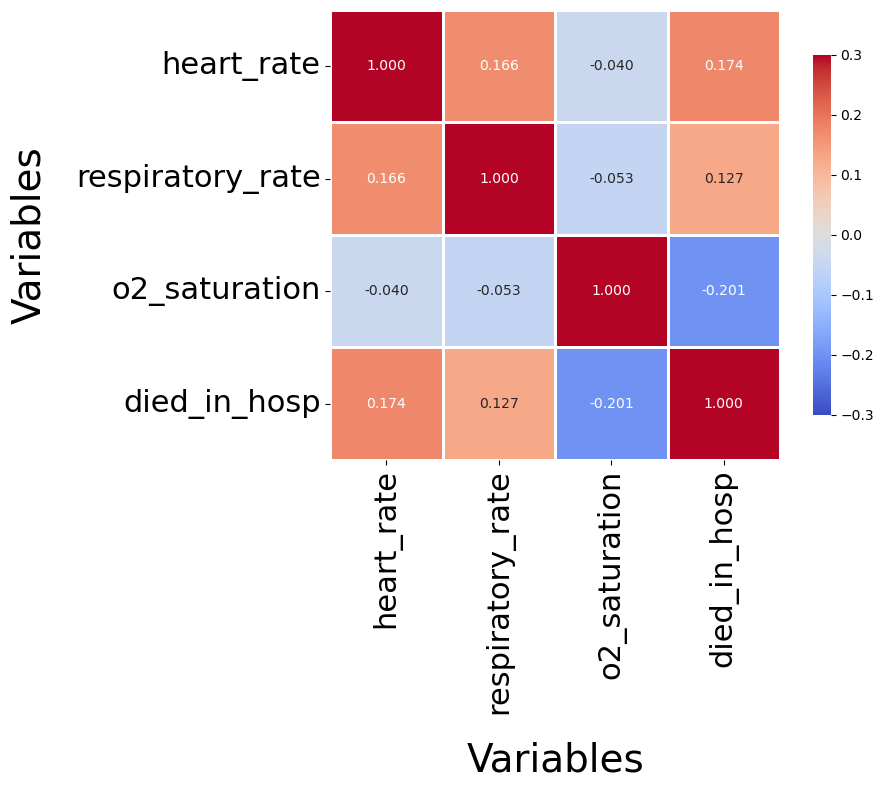

In [ ]:
# Visualize correlation matrix with heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-0.3, vmax=0.3, ax=ax)

# Set much larger x and y axis labels
ax.set_xlabel('Variables', fontsize=28, labelpad=20)
ax.set_ylabel('Variables', fontsize=28, labelpad=20)
# Make sure tick labels are also large
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='x', labelsize=22, rotation=0)
ax.tick_params(axis='y', labelsize=22, rotation=0)

plt.tight_layout()
plt.show()


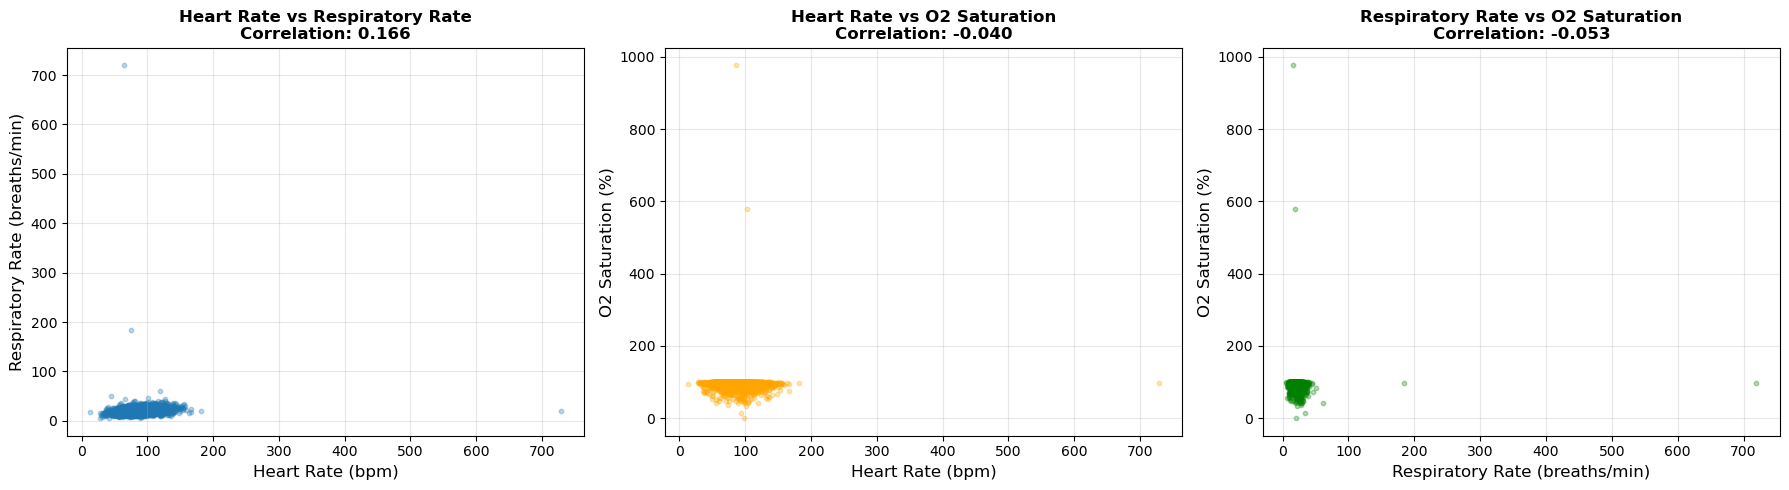

In [12]:
# Create scatter plots for feature-feature correlations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heart Rate vs Respiratory Rate
axes[0].scatter(corr_df_clean['heart_rate'], corr_df_clean['respiratory_rate'], 
                alpha=0.3, s=10)
axes[0].set_xlabel('Heart Rate (bpm)', fontsize=12)
axes[0].set_ylabel('Respiratory Rate (breaths/min)', fontsize=12)
axes[0].set_title(f'Heart Rate vs Respiratory Rate\nCorrelation: {correlation_matrix.loc["heart_rate", "respiratory_rate"]:.3f}', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Heart Rate vs O2 Saturation
axes[1].scatter(corr_df_clean['heart_rate'], corr_df_clean['o2_saturation'], 
                alpha=0.3, s=10, color='orange')
axes[1].set_xlabel('Heart Rate (bpm)', fontsize=12)
axes[1].set_ylabel('O2 Saturation (%)', fontsize=12)
axes[1].set_title(f'Heart Rate vs O2 Saturation\nCorrelation: {correlation_matrix.loc["heart_rate", "o2_saturation"]:.3f}', 
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Respiratory Rate vs O2 Saturation
axes[2].scatter(corr_df_clean['respiratory_rate'], corr_df_clean['o2_saturation'], 
                alpha=0.3, s=10, color='green')
axes[2].set_xlabel('Respiratory Rate (breaths/min)', fontsize=12)
axes[2].set_ylabel('O2 Saturation (%)', fontsize=12)
axes[2].set_title(f'Respiratory Rate vs O2 Saturation\nCorrelation: {correlation_matrix.loc["respiratory_rate", "o2_saturation"]:.3f}', 
                  fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


/var/folders/vz/3dj92k2j6ss19qrpjv8thhsc0000gn/T/ipykernel_89352/570545766.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot([survived['heart_rate'].dropna(), died['heart_rate'].dropna()],
/var/folders/vz/3dj92k2j6ss19qrpjv8thhsc0000gn/T/ipykernel_89352/570545766.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot([survived['respiratory_rate'].dropna(), died['respiratory_rate'].dropna()],
/var/folders/vz/3dj92k2j6ss19qrpjv8thhsc0000gn/T/ipykernel_89352/570545766.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = axes[2].boxplot([survived['o2_saturation'].dropna(),

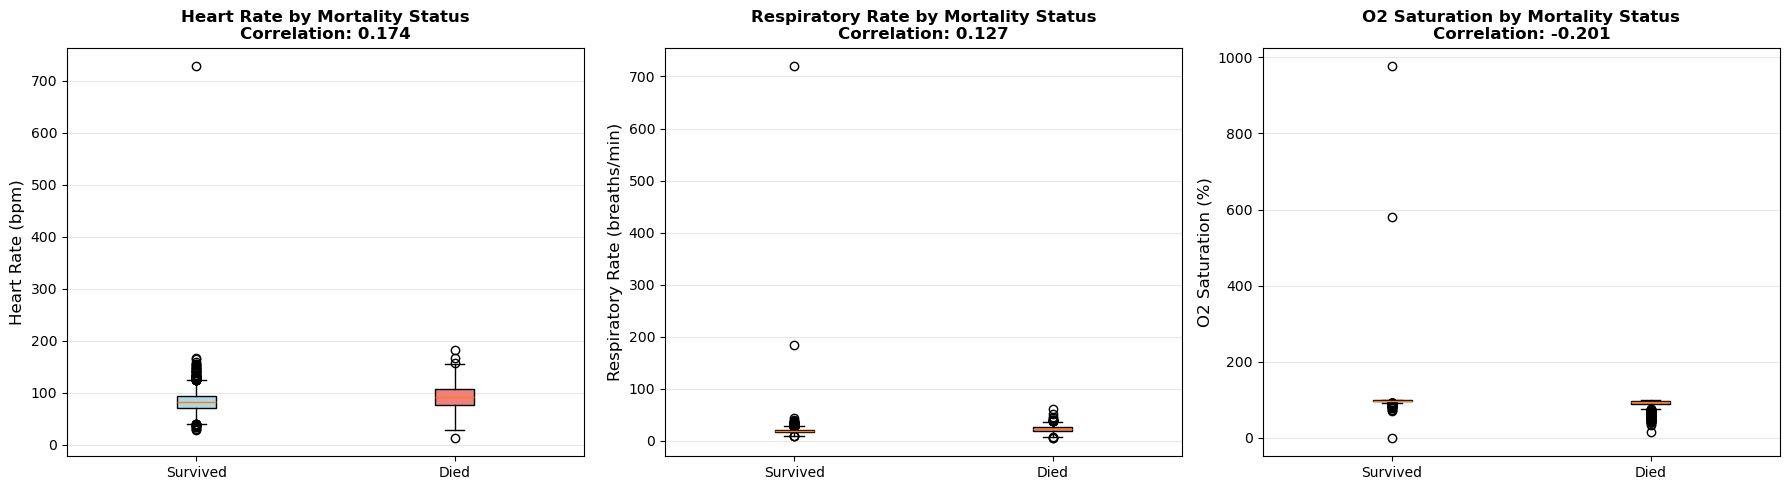

In [13]:
# Create box plots to compare vital signs between survivors and non-survivors
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Prepare data for plotting
survived = corr_df_clean[corr_df_clean['died_in_hosp'] == 0]
died = corr_df_clean[corr_df_clean['died_in_hosp'] == 1]

# Heart Rate
bp1 = axes[0].boxplot([survived['heart_rate'].dropna(), died['heart_rate'].dropna()],
                       labels=['Survived', 'Died'],
                       patch_artist=True)
axes[0].set_ylabel('Heart Rate (bpm)', fontsize=12)
axes[0].set_title(f'Heart Rate by Mortality Status\nCorrelation: {correlation_matrix.loc["heart_rate", "died_in_hosp"]:.3f}', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for patch, color in zip(bp1['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)

# Respiratory Rate
bp2 = axes[1].boxplot([survived['respiratory_rate'].dropna(), died['respiratory_rate'].dropna()],
                       labels=['Survived', 'Died'],
                       patch_artist=True)
axes[1].set_ylabel('Respiratory Rate (breaths/min)', fontsize=12)
axes[1].set_title(f'Respiratory Rate by Mortality Status\nCorrelation: {correlation_matrix.loc["respiratory_rate", "died_in_hosp"]:.3f}', 
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for patch, color in zip(bp2['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)

# O2 Saturation
bp3 = axes[2].boxplot([survived['o2_saturation'].dropna(), died['o2_saturation'].dropna()],
                       labels=['Survived', 'Died'],
                       patch_artist=True)
axes[2].set_ylabel('O2 Saturation (%)', fontsize=12)
axes[2].set_title(f'O2 Saturation by Mortality Status\nCorrelation: {correlation_matrix.loc["o2_saturation", "died_in_hosp"]:.3f}', 
                  fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')
for patch, color in zip(bp3['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)

plt.tight_layout()
plt.show()


In [14]:
# Statistical comparison between survivors and non-survivors
print("="*70)
print("VITAL SIGNS COMPARISON: SURVIVORS VS NON-SURVIVORS")
print("="*70)

for feature in ['heart_rate', 'respiratory_rate', 'o2_saturation']:
    print(f"\n{feature.upper().replace('_', ' ')}:")
    print("-" * 70)
    
    survived_vals = survived[feature].dropna()
    died_vals = died[feature].dropna()
    
    print(f"  Survived (n={len(survived_vals)}):")
    print(f"    Mean: {survived_vals.mean():.2f}")
    print(f"    Median: {survived_vals.median():.2f}")
    print(f"    Std: {survived_vals.std():.2f}")
    print(f"    Range: [{survived_vals.min():.2f}, {survived_vals.max():.2f}]")
    
    print(f"\n  Died (n={len(died_vals)}):")
    print(f"    Mean: {died_vals.mean():.2f}")
    print(f"    Median: {died_vals.median():.2f}")
    print(f"    Std: {died_vals.std():.2f}")
    print(f"    Range: [{died_vals.min():.2f}, {died_vals.max():.2f}]")
    
    print(f"\n  Difference in means: {died_vals.mean() - survived_vals.mean():.2f}")
    print(f"  Difference in medians: {died_vals.median() - survived_vals.median():.2f}")

print("\n" + "="*70)


VITAL SIGNS COMPARISON: SURVIVORS VS NON-SURVIVORS

HEART RATE:
----------------------------------------------------------------------
  Survived (n=8286):
    Mean: 82.82
    Median: 81.69
    Std: 17.13
    Range: [28.73, 728.25]

  Died (n=1537):
    Mean: 91.59
    Median: 91.25
    Std: 22.35
    Range: [13.50, 182.00]

  Difference in means: 8.77
  Difference in medians: 9.56

RESPIRATORY RATE:
----------------------------------------------------------------------
  Survived (n=8286):
    Mean: 18.76
    Median: 18.13
    Std: 8.72
    Range: [8.00, 719.57]

  Died (n=1537):
    Mean: 21.70
    Median: 21.60
    Std: 5.78
    Range: [5.67, 60.83]

  Difference in means: 2.93
  Difference in medians: 3.47

O2 SATURATION:
----------------------------------------------------------------------
  Survived (n=8286):
    Mean: 96.79
    Median: 96.75
    Std: 11.26
    Range: [0.00, 976.55]

  Died (n=1537):
    Mean: 90.50
    Median: 94.11
    Std: 10.52
    Range: [15.00, 100.00]

  

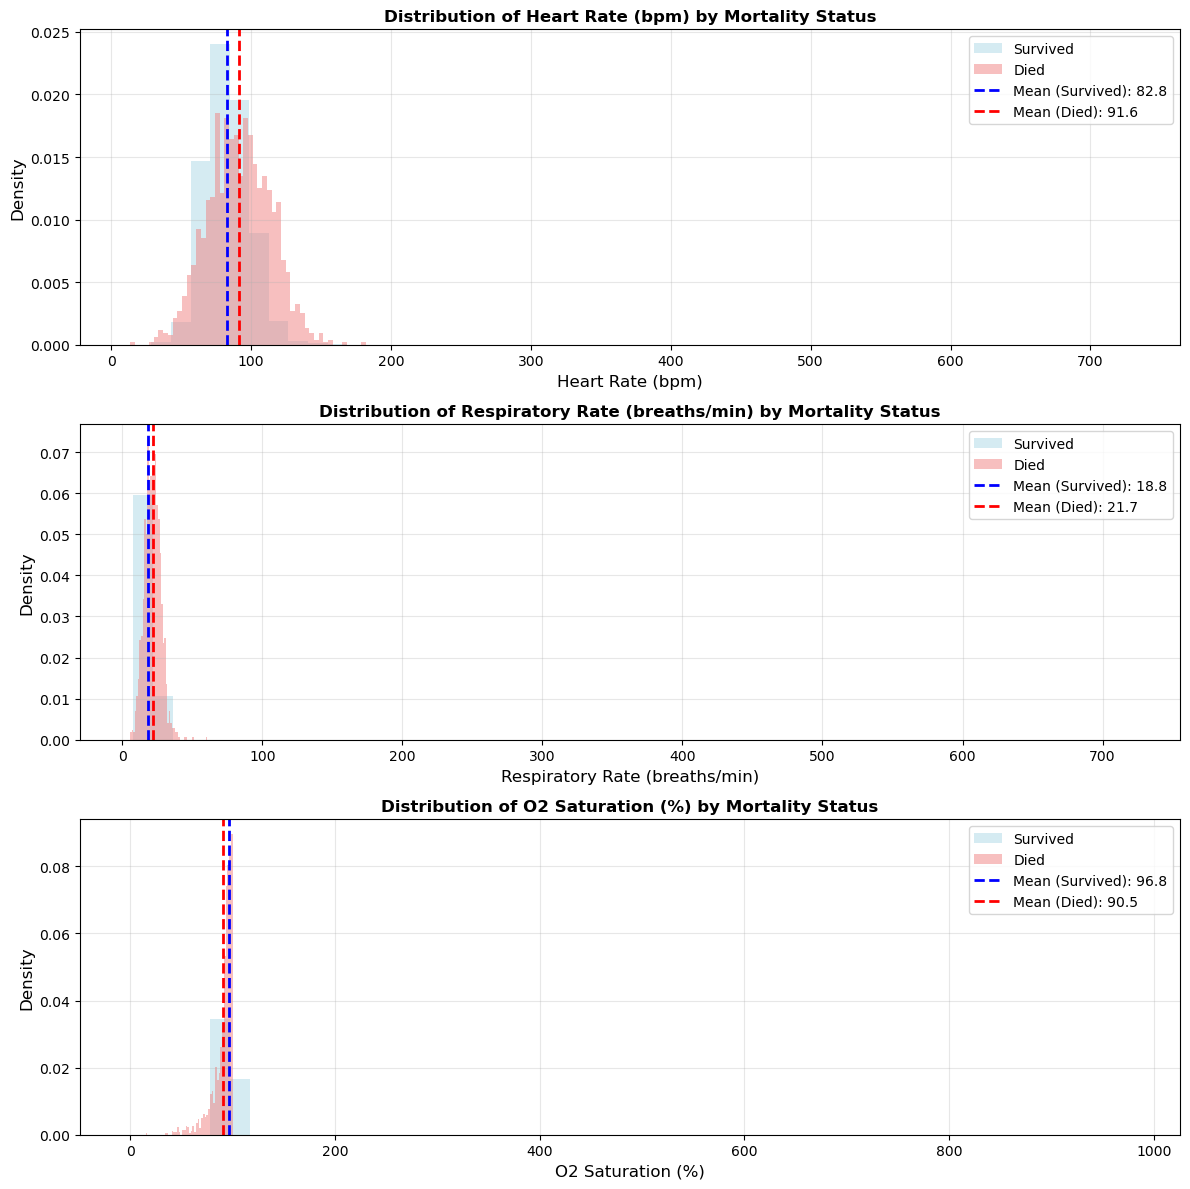

In [15]:
# Distribution plots for each vital sign by mortality status
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

features = [
    ('heart_rate', 'Heart Rate (bpm)', 'blue'),
    ('respiratory_rate', 'Respiratory Rate (breaths/min)', 'orange'),
    ('o2_saturation', 'O2 Saturation (%)', 'green')
]

for idx, (feature, label, color) in enumerate(features):
    # Histogram for survived
    axes[idx].hist(survived[feature].dropna(), bins=50, alpha=0.5, 
                   label='Survived', color='lightblue', density=True)
    
    # Histogram for died
    axes[idx].hist(died[feature].dropna(), bins=50, alpha=0.5, 
                   label='Died', color='lightcoral', density=True)
    
    # Add vertical lines for means
    axes[idx].axvline(survived[feature].mean(), color='blue', linestyle='--', 
                      linewidth=2, label=f'Mean (Survived): {survived[feature].mean():.1f}')
    axes[idx].axvline(died[feature].mean(), color='red', linestyle='--', 
                      linewidth=2, label=f'Mean (Died): {died[feature].mean():.1f}')
    
    axes[idx].set_xlabel(label, fontsize=12)
    axes[idx].set_ylabel('Density', fontsize=12)
    axes[idx].set_title(f'Distribution of {label} by Mortality Status', 
                        fontsize=12, fontweight='bold')
    axes[idx].legend(loc='upper right')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
# Summary of Key Findings
print("="*80)
print("SUMMARY OF CORRELATION ANALYSIS")
print("="*80)
print(f"\nDataset: First 10,000 patients")
print(f"Patients with complete vital sign data: {len(corr_df_clean)}")
print(f"Overall mortality rate: {corr_df_clean['died_in_hosp'].mean():.2%}")

print("\n" + "-"*80)
print("1. INTER-FEATURE CORRELATIONS (among vital signs):")
print("-"*80)
print(f"   • Heart Rate ↔ Respiratory Rate: {correlation_matrix.loc['heart_rate', 'respiratory_rate']:.3f}")
print(f"     → Positive correlation suggests these tend to increase together")
print(f"\n   • Heart Rate ↔ O2 Saturation: {correlation_matrix.loc['heart_rate', 'o2_saturation']:.3f}")
print(f"     → Negative correlation suggests higher heart rate associated with lower O2")
print(f"\n   • Respiratory Rate ↔ O2 Saturation: {correlation_matrix.loc['respiratory_rate', 'o2_saturation']:.3f}")
print(f"     → Negative correlation suggests higher respiratory rate associated with lower O2")

print("\n" + "-"*80)
print("2. MORTALITY PREDICTION (correlation with died_in_hosp):")
print("-"*80)
print(f"   • Heart Rate: {correlation_matrix.loc['heart_rate', 'died_in_hosp']:.3f}")
print(f"     → {'Positive' if correlation_matrix.loc['heart_rate', 'died_in_hosp'] > 0 else 'Negative'} correlation with mortality")
print(f"\n   • Respiratory Rate: {correlation_matrix.loc['respiratory_rate', 'died_in_hosp']:.3f}")
print(f"     → {'Positive' if correlation_matrix.loc['respiratory_rate', 'died_in_hosp'] > 0 else 'Negative'} correlation with mortality")
print(f"\n   • O2 Saturation: {correlation_matrix.loc['o2_saturation', 'died_in_hosp']:.3f}")
print(f"     → {'Positive' if correlation_matrix.loc['o2_saturation', 'died_in_hosp'] > 0 else 'Negative'} correlation with mortality")
print(f"     → Most predictive feature: Lower O2 saturation → Higher mortality risk")

print("\n" + "="*80)


SUMMARY OF CORRELATION ANALYSIS

Dataset: First 10,000 patients
Patients with complete vital sign data: 9823
Overall mortality rate: 15.65%

--------------------------------------------------------------------------------
1. INTER-FEATURE CORRELATIONS (among vital signs):
--------------------------------------------------------------------------------
   • Heart Rate ↔ Respiratory Rate: 0.166
     → Positive correlation suggests these tend to increase together

   • Heart Rate ↔ O2 Saturation: -0.040
     → Negative correlation suggests higher heart rate associated with lower O2

   • Respiratory Rate ↔ O2 Saturation: -0.053
     → Negative correlation suggests higher respiratory rate associated with lower O2

--------------------------------------------------------------------------------
2. MORTALITY PREDICTION (correlation with died_in_hosp):
--------------------------------------------------------------------------------
   • Heart Rate: 0.174
     → Positive correlation with morta